---
title: Implementing a Neural Network from Scratch
subtitle: The DIY Guide to Digital Brain Building
description: First I implement from scratch. Then I progressively reimplement with PyTorch. It is simpler than you think.
image: ../images/20_model_from_scratch/thumbnail.jpeg
author: Salman Naqvi
date: '2024-05-26'
categories: [Creating Models, Programming, Python, PyTorch]
open-graph:
  description: First I implement from scratch. Then I progressively reimplement with PyTorch. It is simpler than you think.
  image: ../images/20_model_from_scratch/thumbnail.jpeg
twitter-card:
  description: First I implement from scratch. Then I progressively reimplement with PyTorch. It is simpler than you think.
  image: ../images/20_model_from_scratch/thumbnail.jpeg
format:
  html: default
  # ipynb: default
filters:
  - line-highlight
---

> This notebook follows the [fastai style guide](https://docs.fast.ai/dev/style.html).

![](../images/20_model_from_scratch/thumbnail.jpeg){fig-alt="The image features a person engaged in wood carving, with their face hidden by a color block. They are wearing an orange robe and using a chisel to create intricate designs on wood. The setting blends elements of a forest and architectural columns, with dramatic lighting that accentuates the carver and their craft. The scene evokes a sense of both indoor and outdoor space, with a focus on the artistry of wood carving."}

:::{.callout-note appearance="simple"}
This notebook is based on the contents taught in part 2 of the [fastai Course](https://course.fast.ai/Lessons/part2.html), led by [Jeremy Howard](https://solve.it.com/#im-jeremy-howard-from-fastai) who created the first LLM, ULMFiT in 2016.
:::

In this notebook, I will implement a neural network from scratch, and iteratively reimplement with PyTorch. That is, I will implement each element of the training and inference process from scratch, before then using the corresponding element in PyTorch. This notebook assumes a prior understanding of the flow and pieces of a neural network.

To recap, the complete training loop of a neural network looks like this.

::::{.grid}

:::{.g-col-4}
:::

:::{.g-col-4}
```{mermaid}
graph TB
  A[Load Data] --> B[Make Predictions] --> C[Compute Loss] --> D[Compute Gradients] --> E[Update Weights] --> F[Compute Metric] --> A
```
::: 

:::{.g-col-4}
:::

::::

This notebook also serves to show the modular nature of PyTorch.

Let's get started with some data.

## Download Data

The goal of our model will be to classify digits from the MNIST dataset.

In [1]:
from pathlib import Path
MNIST_URL = 'https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
d_path = Path('data')
d_path.mkdir(exist_ok=True)
d_path = d_path/'mnist.pkl.gz'

In [2]:
from urllib.request import urlretrieve
if not d_path.exists(): urlretrieve(MNIST_URL, d_path)

In [3]:
! ls -l data

total 33312
-rw-r--r--  1 salmannaqvi  staff  17051982 May 12 12:37 mnist.pkl.gz


In [4]:
import gzip, pickle
from torch import tensor
with gzip.open(d_path, 'rb') as f: ((trn_x, trn_y), (vld_x, vld_y), _) = pickle.load(f, encoding='latin-1')
trn_x, trn_y, vld_x, vld_y = map(tensor, [trn_x[:1000], trn_y[:1000], vld_x[:1000], vld_y[:1000]]) # <1>

1. Taking 1000 samples each for the sake of speed.

## A Single Neuron

A neuron comprises of a set of weights, the linear function, and the activation function.

::::{.grid}

:::{.g-col-4}
:::

:::{.g-col-4}
```{mermaid}
graph LR
  A1[Weights]
  A2[Inputs]
  A1 & A2 --> B[Linear Combination] --> C[Activation Function]
```
:::

:::{.g-col-4}
:::

::::

Our dataset contains one thousand 28x28 pixel samples. Therefore, each sample has 28x28=784 inputs. Since we will be classifying digits, there will be 10 outputs–a probablity for each digit.

In [5]:
n, m = trn_x.shape
c = trn_y.max() + 1
n, m, c

(1000, 784, tensor(10))

Let's have 50 neurons comprise the hidden layer.

In [6]:
nh = 50

From these dimensions, we can create our appropriate weights...

In [7]:
import torch; torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
w1, b1 = torch.randn(m, nh), torch.zeros(nh)
w2, b2 = torch.randn(nh, 1), torch.zeros(1)
w1.shape, b1.shape, w2.shape, b2.shape

(torch.Size([784, 50]), torch.Size([50]), torch.Size([50, 1]), torch.Size([1]))

...and create our linear model!

In [8]:
def lin(x, w, b): return x @ w + b

In [9]:
t = lin(vld_x, w1, b1); t.shape

torch.Size([1000, 50])

In [10]:
vld_x.shape, w1.shape

(torch.Size([1000, 784]), torch.Size([784, 50]))

In [11]:
from fastcore.all import *
import torch.nn.functional as F
test_eq(lin(vld_x, w1, b1), F.linear(vld_x, w1.T, b1))

Our implementation produces the same outputs as PyTorch's implementation.

We now need to implement the activation function, which will be the ReLU (rectified linear unit). Any value less than 0 gets clipped to 0. There are multiple ways we can approach doing this, such as using `torch.max`.

In [12]:
#| column: margin
?torch.max

Docstring:
max(input) -> Tensor

Returns the maximum value of all elements in the ``input`` tensor.

.. warning::
    This function produces deterministic (sub)gradients unlike ``max(dim=0)``

Args:
    input (Tensor): the input tensor.

Example::

    >>> a = torch.randn(1, 3)
    >>> a
    tensor([[ 0.6763,  0.7445, -2.2369]])
    >>> torch.max(a)
    tensor(0.7445)

.. function:: max(input, dim, keepdim=False, *, out=None) -> (Tensor, LongTensor)
   :noindex:

Returns a namedtuple ``(values, indices)`` where ``values`` is the maximum
value of each row of the :attr:`input` tensor in the given dimension
:attr:`dim`. And ``indices`` is the index location of each maximum value found
(argmax).

If ``keepdim`` is ``True``, the output tensors are of the same size
as ``input`` except in the dimension ``dim`` where they are of size 1.
Otherwise, ``dim`` is squeezed (see :func:`torch.squeeze`), resulting
in the output tensors having 1 fewer dimension than ``input``.

.. note:: If there are mu

In [13]:
torch.max(tensor([-5, 2, 3, -4]), tensor([0]))

tensor([0, 2, 3, 0])

In [14]:
def relu(x): return torch.max(x, tensor([0]))

Another way is to use `torch.clamp_min`, which is more idiomatic for this case.

In [15]:
def relu(x): return x.clamp_min(0.)

In [16]:
t = lin(vld_x, w1, b1)
test_eq(relu(t), F.relu(t))

A single neuron can now be constructed.

In [17]:
def model(xb):
  l1 = relu(lin(xb, w1, b1))
  return lin(l1, w2, b2)

In [18]:
res = model(vld_x); res.shape

torch.Size([1000, 1])

## Loss Function

With the forward pass being implemented, it is time to determine the loss. Even though we have a multi-class classification problem at hand, I will use mean squared error for simplicity. Later in this post, I will switch to cross entropy loss.

The Mean Squared Error (MSE) between two vectors can be represented as:

$$
\text{MSE} = \frac{\sum_{i=1}^{n} (y_i - x_i)^2}{n}
$$

where $x$ and $y$ are vectors of length $n$, and $x_i$ and $y_i$ represent the $i$-th elements of the vectors.

::: {.callout-note appearance="simple"}
MSE in its most basic form looks like this.

$$
\text{MSE} = \frac{(y - x)^2}{1}
$$

If we have multiple data points, then it looks like this.

$$
\text{MSE} = \frac{(y_1 - x_1)^2+(y_2 - x_2)^2+(y_3 - x_3)^2}{3}
$$
:::

The tensor holding the predictions and the tensor holding the targets have different shapes. Therefore, there are different ways in which both can be subtracted from each other.

In [19]:
res.shape, vld_y.shape

(torch.Size([1000, 1]), torch.Size([1000]))

In [20]:
(vld_y - res).shape

torch.Size([1000, 1000])

In [21]:
(vld_y[:, None] - res).shape

torch.Size([1000, 1])

In [22]:
res[:, 0].shape, res.squeeze().shape

(torch.Size([1000]), torch.Size([1000]))

In [23]:
(vld_y - res[:, 0]).shape

torch.Size([1000])

However, it will be better to add a column to `vld_y` rather than remove a column from `res`, so as to keep the shape of all tensors consistent (i.e., all tensors having a row and column, as opposed to some having rows and columns, and others having only a column).

In [24]:
((vld_y[:, None] - res)**2).sum() / res.shape[0]

tensor(717.17)

In [25]:
def mse(preds, targs): return (targs[:, None] - preds).pow(2).mean()

In [26]:
preds = model(trn_x); mse(preds, trn_y)

tensor(648.87)

In [27]:
test_eq(mse(preds, trn_y), F.mse_loss(preds, trn_y[:, None]))

## Backward Pass

Now comes the backward pass; the pass responsible for computing the gradients of our model's weights.

For brevity, I will not explain why I compute the gradients the way I do. It can be taken that the way I compute them is due to the result of calculating the derivatives of the foward pass by hand. If you would like to explore how I did so, you can refer to my other blog post, [Backpropagation Explained using English Words*](18_backprop_from_scratch.qmd).

In short, the derivatives compute to be the following.

:::{.callout}
$$
\begin{align}
  \frac{\partial \text{MSE}}{\partial \vec{\rm{w}}_1} &=
    \begin{cases}
      0 & \vec{\rm{x}}_i \cdot \vec{\rm{w}}_1 + b_1 ≤ 0 \\
      \frac{2}{N} \sum^N_{i=1} (\text{max}(0, \vec{\rm{x}}_i \cdot \vec{\rm{w}}_1 + b_1) \cdot \vec{\rm{w}}_2 + b_2 - \vec{\rm{y}}_i) \cdot \vec{\rm{w}}^T_2 \cdot \vec{\rm{x}}_i^T & \vec{\rm{x}}_i \cdot \vec{\rm{w}}_1 + b_1 > 0
    \end{cases} \\
  \frac{\partial \text{MSE}}{\partial b_1} &=
    \begin{cases}
      0 & \vec{\rm{x}}_i \cdot \vec{\rm{w}}_1 + b_1 ≤ 0 \\
      \frac{2}{N} \sum^N_{i=1} (\text{max}(0, \vec{\rm{x}}_i \cdot \vec{\rm{w}}_1 + b_1) \cdot \vec{\rm{w}}_2 + b_2 - \vec{\rm{y}}_i) \cdot \vec{\rm{w}}_2^T & \vec{\rm{x}}_i \cdot \vec{\rm{w}}_1 + b_1 > 0
    \end{cases} \\
  \frac{\partial \text{MSE}}{\partial \vec{\rm{x}}_i} &=
    \begin{cases}
      0 & \vec{\rm{x}}_i \cdot \vec{\rm{w}}_1 + b_1 ≤ 0 \\
      \frac{2}{N} \sum^N_{i=1} (\text{max}(0, \vec{\rm{x}}_i \cdot \vec{\rm{w}}_1 + b_1) \cdot \vec{\rm{w}}_2 + b_2 - \vec{\rm{y}}_i) \cdot \vec{\rm{w}}^T_2 \cdot \vec{\rm{w}}_1^T & \vec{\rm{x}}_i \cdot \vec{\rm{w}}_1 + b_1 > 0
    \end{cases} \\
  \frac{\partial \text{MSE}}{\partial \vec{\rm{w}}_2} &= \frac{2}{N} \sum^N_{i=1} (\text{max}(0, \vec{\rm{x}}_i \cdot \vec{\rm{w}}_1 + b_1) \cdot \vec{\rm{w}}_2 + b_2 - \vec{\rm{y}}_i) \cdot \text{max}(0, \vec{\rm{x}}_i \cdot \vec{\rm{w}}_1 + b_1) \\
  \frac{\partial \text{MSE}}{\partial b_2} &= \frac{2}{N} \sum^N_{i=1} \text{max}(0, \vec{\rm{x}}_i \cdot \vec{\rm{w}}_1 + b_1) \cdot \vec{\rm{w}}_2 + b_2 - \vec{\rm{y}}_i
\end{align}
$$
:::

When implementing backpropagation, it is better to implement the entire equation in pieces, by storing the result of each intermediate gradient. These intermediate gradients can then be reused to calculate the gradients of another variable.

Let's prepare the pieces we'll need and get started.

In [28]:
l1 = relu(lin(trn_x, w1, b1))
l2 = lin(l1, w2, b2)
loss = mse(l2, trn_y); loss

tensor(648.87)

### `w1` Gradients

This is the maths to compute the gradients for `w1`, as also shown above.

$$
  \frac{\partial \text{MSE}}{\partial \vec{\rm{w}}_1} =
    \begin{cases}
      0 & \text{if } \vec{\rm{x}}_i \cdot \vec{\rm{w}}_1 + b_1 \leq 0 \\
      \frac{2}{N} \sum^N_{i=1} (\text{max}(0, \vec{\rm{x}}_i \cdot \vec{\rm{w}}_1 + b_1) \cdot \vec{\rm{w}}_2 + b_2 - \vec{\rm{y}}_i) \cdot \vec{\rm{w}}^T_2 \cdot \vec{\rm{x}}_i^T & \text{if } \vec{\rm{x}}_i \cdot \vec{\rm{w}}_1 + b_1 > 0
    \end{cases}
$$

::::{.callout-note appearance="simple"}
Here, you can see the individual pieces I will compute to implement this equation.

:::{.callout-note appearance="minimal" collapse="true"}
## Substitutions
$$
\begin{align}
    u_1 &= \vec{\rm{x}}_i \cdot \vec{\rm{w}}_1 + b_1 \\
    u_2 &= \text{max}(0, u_1) \\
    u_3 &= u_2 \cdot \vec{\rm{w}}_2 + b_2 \\
    u_4 &= \vec{\rm{y}}_i - u_3 \\
    u_5 &= u_4^2
\end{align}
$$
:::

:::{.callout-note appearance="minimal" collapse="true"}
## Derivatives of the Substitutions
$$
\begin{alignat}{4}
  \text{gradient of } u_4 &= \frac{\partial u_5}{\partial u_4} &&=
  \frac{\partial}{\partial u_4} u_4^2 &&&= 2u_4 \\
  \text{gradient of } u_3 &= \frac{\partial u_4}{\partial u_3} &&= \frac{\partial}{\partial u_3} \vec{\rm{y}}_i - u_3 &&&= -1 \\
  \text{gradient of } u_2 &= \frac{\partial u_3}{\partial u_2} &&= \frac{\partial}{\partial u_2} u_2 \cdot \vec{\rm{w}}_2 + b_2 &&&= \vec{\rm{w}}^T_2 \\
  \text{gradient of } u_1 &= \frac{\partial \vec{\rm{u}}_2}{\partial \vec{\rm{u}}_1} &&= \frac{\partial}{\partial u_1} \text{max}(0, u_1) &&&= 
    \begin{cases}
      0 & \vec{\rm{u}}_1 ≤ 0 \\
      1 & \vec{\rm{u}}_1 > 0
    \end{cases} \\
  \text{gradient of } \vec{\rm{w}}_1 &= \frac{\partial u_1}{\partial \vec{\rm{w}}_1} &&= \frac{\partial}{\partial w_1} \vec{\rm{x}}_i \cdot \vec{\rm{w}}_1 + b_1 &&&= \vec{\rm{x}}^T_i
\end{alignat}
$$
:::
::::

In [29]:
diff = trn_y[:, None] - l2; diff.shape

torch.Size([1000, 1])

In [30]:
loss.g = (2/n) * diff; loss, loss.g.shape

(tensor(648.87), torch.Size([1000, 1]))

In [31]:
diff.g = -1 * loss.g; diff[:5], diff.shape

(tensor([[-15.34],
         [-33.46],
         [-35.26],
         [ -6.92],
         [-21.55]]),
 torch.Size([1000, 1]))

In [32]:
(w2.shape, diff.g.shape), (w2.T.shape, diff.g[:, None].shape)

((torch.Size([50, 1]), torch.Size([1000, 1])),
 (torch.Size([1, 50]), torch.Size([1000, 1, 1])))

In [33]:
(diff.g @ w2.T).shape

torch.Size([1000, 50])

In [34]:
l2.g = diff.g @ w2.T; l2.g.shape

torch.Size([1000, 50])

In [35]:
(l1 > 0).float()

tensor([[0., 1., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 1., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [1., 1., 0.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

In [36]:
l1.g = l2.g * (l1 > 0).float(); l1.g.shape

torch.Size([1000, 50])

In [37]:
(l1.g.shape, trn_x.shape), (l1.g[:, None, :].shape, trn_x[..., None].shape)

((torch.Size([1000, 50]), torch.Size([1000, 784])),
 (torch.Size([1000, 1, 50]), torch.Size([1000, 784, 1])))

In [38]:
w1.g = tensor([1, 2])

In [39]:
w1.g = (l1.g[:, None, :] * trn_x[..., None]).sum(0); w1.g.shape

torch.Size([784, 50])

In [40]:
(w1.shape, w1.g.shape), (w1.g.min(), w1.g.max())

((torch.Size([784, 50]), torch.Size([784, 50])),
 (tensor(-17.50), tensor(25.09)))

Let's verify our derivation is correct by comparing it to the gradients computed by PyTorch.

In [41]:
w1_ = w1.clone().requires_grad_();

In [42]:
l1 = relu(lin(trn_x, w1_, b1))
l2 = lin(l1, w2, b2)
loss = mse(l2, trn_y)
loss.backward()

In [43]:
w1_.grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [44]:
(w1.g.min(), w1.g.max()), (w1_.grad.min(), w1_.grad.max())

((tensor(-17.50), tensor(25.09)), (tensor(-17.50), tensor(25.09)))

In [45]:
test_close(w1.g, w1_.grad, eps=0.01)

It is!

### `b1` Gradients

As previously mentioned, I can reuse the computed gradients to calculate the gradients for $b_1$. For now though, I will show the entire implemention for easy reference and later, when we will encapsulate the backward pass, I will reuse the already computed gradients.

In [46]:
diff = trn_y[:, None] - l2
loss.g = (2/n) * diff
diff.g = loss.g * -1
l2.g = diff.g @ w2.T
l1.g = l2.g * (l1 > 0).float()
l1.g.shape, b1.shape

(torch.Size([1000, 50]), torch.Size([50]))

In [47]:
b1.g = (l1.g * 1).sum(0); b1.g.shape

torch.Size([50])

In [48]:
b1.min(), b1.max()

(tensor(0.), tensor(0.))

###  `trn_x` Gradients

In [49]:
diff = trn_y[:, None] - l2
loss.g = (2/n) * diff
diff.g = loss.g * -1
l2.g = diff.g @ w2.T
l1.g = l2.g * (l1 > 0).float()
l1.g.shape, w1.shape

(torch.Size([1000, 50]), torch.Size([784, 50]))

In [50]:
trn_x.g = l1.g @ w1.T

In [51]:
trn_x.g.min(), trn_x.g.max()

(tensor(-2.85, grad_fn=<MinBackward1>), tensor(2.85, grad_fn=<MaxBackward1>))

### `w1` Gradients

In [52]:
diff = trn_y[:, None] - l2
loss.g = (2/n) * diff
diff.g = loss.g * -1
diff.g.shape, l1.shape


(torch.Size([1000, 1]), torch.Size([1000, 50]))

In [53]:
(diff.g * l1).sum(0, keepdim=True).T.shape

torch.Size([50, 1])

In [54]:
(diff.g[:, None, :] * l1[..., None]).sum(0).shape

torch.Size([50, 1])

In [55]:
w2.g = (diff.g[:, None, :] * l1[..., None]).sum(0); w2.g.shape

torch.Size([50, 1])

In [56]:
w2.g.min(), w2.g.max()

(tensor(8.37, grad_fn=<MinBackward1>), tensor(388.44, grad_fn=<MaxBackward1>))

### `b2` Gradients

In [57]:
diff = trn_y[:, None] - l2
loss.g = (2/n) * diff
diff.g = loss.g * -1
b2.g = (diff.g * 1).sum(0)
b2.g.shape, b2.shape


(torch.Size([1]), torch.Size([1]))

### Verify

Let's verify our remaining gradients.

In [58]:
#| column: margin
w1_, b1_, w2_, b2_, trn_x_ = [lambda w: w.clone.requires_grad_() for w in [w1, b1, w2, b2, trn_x]]

:::{.column-margin}
The expression above does not work to create copies. Rather than returning a cloned copy that requires gradients, lambda objects will be returned.
:::

In [59]:
w1_, b1_, w2_, b2_, trn_x_ = map(lambda w: w.clone().requires_grad_(), [w1, b1, w2, b2, trn_x])

In [60]:
#| column: margin
#| echo: false
w1_

tensor([[-2.81, -1.72, -0.97,  ..., -0.29, -1.62, -0.45],
        [-1.77, -0.17,  1.32,  ..., -0.92,  0.76,  2.77],
        [ 0.58,  2.13, -0.98,  ...,  0.41,  1.50,  0.86],
        ...,
        [-0.50, -1.90, -0.10,  ..., -1.61,  0.78, -0.09],
        [ 0.89,  0.50,  1.21,  ...,  0.93, -0.37, -0.85],
        [ 0.57, -0.50, -1.47,  ...,  0.72,  1.64, -0.85]], requires_grad=True)

In [61]:
w1_

tensor([[-2.81, -1.72, -0.97,  ..., -0.29, -1.62, -0.45],
        [-1.77, -0.17,  1.32,  ..., -0.92,  0.76,  2.77],
        [ 0.58,  2.13, -0.98,  ...,  0.41,  1.50,  0.86],
        ...,
        [-0.50, -1.90, -0.10,  ..., -1.61,  0.78, -0.09],
        [ 0.89,  0.50,  1.21,  ...,  0.93, -0.37, -0.85],
        [ 0.57, -0.50, -1.47,  ...,  0.72,  1.64, -0.85]], requires_grad=True)

In [62]:
l1 = relu(lin(trn_x_, w1_, b1_))
l2 = lin(l1, w2_, b2_)
loss = mse(l2, trn_y)
loss.backward()

In [63]:
for a, b in zip((w1, b1, w2, b2, trn_x), (w1_, b1_, w2_, b2_, trn_x_)): test_close(a.g, b.grad, eps=1e-2)

All comparisons passed!

## Encapsulate

Now that we have the forward and backward passes sorted, let us cohesively bring them together.

In [64]:
def forward(inps, targs):
  l1 = relu(lin(inps, w1, b1))
  l2 = lin(l1, w2, b2)
  loss = mse(l2, targs)
  return l1, l2, loss

def backward(inps, targs, l1, l2, loss):
  diff = targs[:, None] - l2
  loss.g = (2 / n) * diff
  diff.g = loss.g * -1

  w2.g = (diff.g[:, None, :] * l1[..., None]).sum(0)
  b2.g = (diff.g * 1).sum(0)

  l2.g = diff.g @ w2.T
  l1.g = l2.g * (l1 > 0).float()

  w1.g = (l1.g[:, None, :] * trn_x[..., None]).sum(0)
  b1.g = (l1.g * 1).sum(0)

  inps.g = l1.g @ w1.T

In [65]:
l1, l2, loss = forward(trn_x, trn_y)
backward(trn_x, trn_y, l1, l2, loss)

In [66]:
def comp_grads(*ws):
  for a, b in zip(ws, (w1_, b1_, w2_, b2_, trn_x_)): test_close(a.g, b.grad, eps=1e-2)

In [67]:
comp_grads(w1, b1, w2, b2, trn_x)

The `backward` function can be further refactored by taking the gradient computations of the linear layers common.

In [68]:
def backward(inps, targs, l1, l2, loss):
  diff = targs[:, None] - l2
  loss.g = (2/n) * diff
  diff.g = loss.g * -1

  lin_grad(l1, diff, w2, b2)
  l2.g = diff.g @ w2.T
  l1.g = l2.g * (l1 > 0).float()
  lin_grad(inps, l1, w1, b1)

def lin_grad(inp, out, w, b):
  inp.g = out.g @ w.T
  w.g = (out.g[:, None, :] * inp[..., None]).sum(0)
  b.g = (out.g * 1).sum(0)

::::{.column-margin}

Previous implementation.

```py
def backward(inps, targs, l1, l2, loss):
  diff = targs[:, None] - l2
  loss.g = (2 / n) * diff
  diff.g = loss.g * -1

  w2.g = (diff.g[:, None, :] * l1[..., None]).sum(0)
  b2.g = (diff.g * 1).sum(0)

  l2.g = diff.g @ w2.T
  l1.g = l2.g * (l1 > 0).float()

  w1.g = (l1.g[:, None, :] * trn_x[..., None]).sum(0)
  b1.g = (l1.g * 1).sum(0)

  inps.g = l1.g @ w1.T
  ```

::::

In [69]:
backward(trn_x, trn_y, *forward(trn_x, trn_y))

In [70]:
comp_grads(w1, b1, w2, b2, trn_x)

### Class

Currently, we have functions that each separately handle a part of the network. For instance, `mse` only computes its respective portion of the forward pass: the mean squared error. `backward` is a separate function that handles the backward pass for all pieces of the network.

Let us change how this works, so each piece of the network also handles its respective backward pass. This means, `mse` will have the ability to compute both its forward pass and backward pass.

In [71]:
class MSE:
  def __call__(self, inp, targs):
    self.inp,self.targs = inp,targs
    self.out = (inp[:, 0] - targs).pow(2).mean()
    return self.out
  
  def backward(self): self.inp.g = (2 / self.inp.shape[0]) * (self.inp[:, 0] - self.targs)[..., None]

In [72]:
test_eq(MSE()(preds, trn_y), mse(preds, trn_y))

In [73]:
class Lin:
  def __init__(self, w, b): self.w,self.b = w,b

  def __call__(self, inp):
    self.inp = inp
    self.out = self.inp @ self.w + self.b
    return self.out
  
  def backward(self):
    self.inp.g = self.out.g @ self.w.T
    self.w.g = (self.out.g[:, None, :] * self.inp[..., None]).sum(0)
    self.b.g = self.out.g.sum(0)

In [74]:
test_eq(Lin(w1, b1)(trn_x), lin(trn_x, w1, b1))

In [75]:
class ReLU:
  def __call__(self, inp):
    self.inp = inp
    self.out = self.inp.clamp_min(0.)
    return self.out
  
  def backward(self): self.inp.g = self.out.g * (self.inp > 0).float()

In [76]:
test_eq(ReLU()(l1), relu(l1))

In [77]:
class Model:
  def __init__(self, w1, b1, w2, b2):
    self.layers = [Lin(w1, b1), ReLU(), Lin(w2, b2)]
    self.loss = MSE()
  
  def __call__(self, inp, targs):
    for l in self.layers: inp = l(inp)
    return self.loss(inp, targs)
  
  def backward(self):
    self.loss.backward()
    for l in self.layers[::-1]: l.backward()

In [78]:
model = Model(w1, b1, w2, b2)
l = model(trn_x, trn_y)
model.backward()

In [79]:
comp_grads(w1, b1, w2, b2, trn_x)

### Super Class

The classes we have created have common functionality, meaning their is still room for further refactoring. In particular, all the classes store the forward pass arguments as attributes if needed, have a `__call__` dunder method that exectutes the forward pass, and a `backward` method for the backward pass.

In [80]:
class Module():
  def __call__(self, *args):
    self.args = args
    self.out = self.forward(*args)
    return self.out
  
  def forward(self): raise Exception('Forward pass not implemented')
  def backward(self): self.bwd(self.out, *self.args)
  def bwd(self): raise Exception('Backward pass not implemented.')

In [81]:
class MSE(Module):
  def forward(self, inp, targs): return (inp[:, 0] - targs).pow(2).mean()
  def bwd(self, out, inp, targs): inp.g = (2 / inp.shape[0]) * (inp[:, 0] - targs)[..., None]

In [82]:
test_eq(MSE()(preds, trn_y), mse(preds, trn_y))

In [83]:
class Lin(Module):
  def __init__(self, w, b): self.w,self.b = w,b
  def forward(self, inp): return inp @ self.w + self.b
  def bwd(self, out, inp):
    inp.g = out.g @ self.w.T
    self.w.g = (out.g[:, None, :] * inp[..., None]).sum(0)
    self.b.g = out.g.sum(0)
    

In [84]:
test_eq(Lin(w1, b1)(trn_x), lin(trn_x, w1, b1))

In [85]:
class ReLU(Module):
  def forward(self, inp): return inp.clamp_min(0.)
  def bwd(self, out, inp): inp.g = out.g * (inp > 0).float()

In [86]:
test_eq(ReLU()(l1), relu(l1))

In [87]:
model = Model(w1, b1, w2, b2)
loss = model(trn_x, trn_y)
model.backward()

In [88]:
comp_grads(w1, b1, w2, b2)

And with that, this is the basic underlying paradigm in which PyTorch implements its components.

So let us now directly use PyTorch's `nn.Module` to handle our components. There is an added benefit that `nn.Module` automatically keeps track of our gradients, so we do not need to implement the backward pass.

### PyTorch's `nn.Module`

In [89]:
w1.shape, n, m, c, b1.shape

(torch.Size([784, 50]), 1000, 784, tensor(10), torch.Size([50]))

In [90]:
from torch import nn
class Linear(nn.Module):
  def __init__(self, n_inps, n_outs):
    super().__init__()
    self.w = torch.randn(n_inps, n_outs).requires_grad_()
    self.b = torch.randn(n_outs).requires_grad_()
  
  def forward(self, inp): return inp @ self.w + self.b

In [91]:
F = nn.functional
class Model(nn.Module):
  def __init__(self, n_inp, nh, n_out):
    super().__init__()
    self.layers = [Linear(n_inp, nh), nn.ReLU(), Linear(nh, n_out)]
  
  def __call__(self, inp, targ):
    for l in self.layers: inp = l(inp)
    return F.mse_loss(inp, targ[:, None])

In [92]:
model = Model(m, nh, 1)
loss = model(trn_x, trn_y.float())
loss.backward()

In [93]:
model.layers

[Linear(), ReLU(), Linear()]

In [94]:
l0 = model.layers[0]; l0.b.grad

tensor([ 42.11, -25.91,   0.15,  15.73, -16.16,  41.61,  13.73,  81.32,  -8.91,  55.30, -14.12, -82.24,  12.02, -27.58,  -9.48, -90.85,
        -25.55,  34.89,  -0.68, -14.24,   4.73,  49.70, -27.02,  19.55,  10.14,  38.86,  30.55,  74.17,   2.15,  -2.62, -37.11,  14.04,
        -12.12,   0.89,  -0.99,  -6.29,  -1.15,  12.26,  -9.73,  -4.13,  -1.53,   1.67,   1.34,  -9.78,  20.50,   7.30,  62.45,   5.94,
         -3.28, -18.14])

---

## Cross Entropy Loss

Let's now implement a much more appropriate loss function for our multi-target problem: cross entropy loss.

In [95]:
#| code-fold: true
#| code-summary: Redefinition of `Model`, but without with loss function.
class Model(nn.Module):
  def __init__(self, n_inps, nh, n_outs):
    super().__init__()
    self.layers = [nn.Linear(n_inps, nh), nn.ReLU(), nn.Linear(nh, n_outs)]

  def __call__(self, x):
    for l in self.layers: x = l(x)
    return x

In [96]:
model = Model(m, nh, c)
preds = model(trn_x); preds.shape

torch.Size([1000, 10])

As I have defined [here](../../dictionary/terms/cross_entropy_loss.qmd), cross entropy loss simply involves taking the logarithm of the softmax function, and multiplying the results with the [one hot encoded](../../dictionary/terms/one_hot_encoding.qmd) targets.

[Softmax](../../dictionary/terms/softmax.qmd), a multi-class generalization of the sigmoid function, involves taking the exponent of each prediction, and dividing each resulting value with the sum of all predictions to the exponent.

$$
\text{S}(y_i) = \frac{e^{y_i}}{\sum_{j} e^{y_j}}
$$

:::{.callout-note appearance="simple"}
# Sigmoid Function Definition
$$
\sigma(y) = \frac{1}{1 + e^{-y}}
$$
:::

Let's begin by first taking the logarithm of the softmax function.

In [97]:
def log_softmax(x): return ((x.exp() / x.exp().sum(-1, keepdim=True))).log()
log_softmax(preds)

tensor([[-2.40, -2.33, -2.25,  ..., -2.33, -2.40, -2.34],
        [-2.37, -2.44, -2.21,  ..., -2.30, -2.34, -2.28],
        [-2.37, -2.45, -2.16,  ..., -2.24, -2.40, -2.40],
        ...,
        [-2.36, -2.45, -2.20,  ..., -2.24, -2.39, -2.37],
        [-2.34, -2.41, -2.28,  ..., -2.20, -2.53, -2.25],
        [-2.43, -2.37, -2.21,  ..., -2.26, -2.40, -2.37]], grad_fn=<LogBackward0>)

In [98]:
F.log_softmax(preds, dim=-1)

tensor([[-2.40, -2.33, -2.25,  ..., -2.33, -2.40, -2.34],
        [-2.37, -2.44, -2.21,  ..., -2.30, -2.34, -2.28],
        [-2.37, -2.45, -2.16,  ..., -2.24, -2.40, -2.40],
        ...,
        [-2.36, -2.45, -2.20,  ..., -2.24, -2.39, -2.37],
        [-2.34, -2.41, -2.28,  ..., -2.20, -2.53, -2.25],
        [-2.43, -2.37, -2.21,  ..., -2.26, -2.40, -2.37]], grad_fn=<LogSoftmaxBackward0>)

In [99]:
test_close(log_softmax(preds).detach(), F.log_softmax(preds, dim=-1).detach())

Our implementation involves division. According to the rule, $\lg\left(\frac{a}{b}\right) = \lg(a) - \lg(b)$, we can simplify our computation by subtracting the numerators and denominators instead.

In [100]:
def log_softmax(x): return x.exp().log() - x.exp().sum(-1, keepdim=True).log()

In [101]:
log_softmax(preds)

tensor([[-2.40, -2.33, -2.25,  ..., -2.33, -2.40, -2.34],
        [-2.37, -2.44, -2.21,  ..., -2.30, -2.34, -2.28],
        [-2.37, -2.45, -2.16,  ..., -2.24, -2.40, -2.40],
        ...,
        [-2.36, -2.45, -2.20,  ..., -2.24, -2.39, -2.37],
        [-2.34, -2.41, -2.28,  ..., -2.20, -2.53, -2.25],
        [-2.43, -2.37, -2.21,  ..., -2.26, -2.40, -2.37]], grad_fn=<SubBackward0>)

Our implementation has an issue though: it is unstable. Anything involving exponents is inherently unstable. Have a large enough value, and we converge to infinity relatively quickly.

In [102]:
for x in range(0, 101, 10): print(f'e^{x}={torch.exp(tensor(x))}')

e^0=1.0
e^10=22026.46484375
e^20=485165184.0
e^30=10686474223616.0
e^40=2.353852703404196e+17
e^50=5.184705457665547e+21
e^60=1.1420073962419164e+26
e^70=2.515438700355918e+30
e^80=5.540622484676759e+34
e^90=inf
e^100=inf


Fortunately, there is trick to overcoming this known as the LogSumExp simplification.

$$
\lg\left(\sum^n_{j=1} e^{x_j}\right) = \lg\left(e^a \sum^n_{j=1} \frac{e^{x_j}}{e^a}\right) = \lg\left(e^a \sum^n_{j=1} e^{x_j - a}\right) = a + \lg\left(\sum^n_{j=1} e^{x_j - a}\right)
$$

$a$ is the largest element in $x$.

To begin, we need to get the largest value in each sample.

In [103]:
max = preds.max(-1)[0]; max.shape, preds.shape

(torch.Size([1000]), torch.Size([1000, 10]))

In [104]:
#| column: margin
?torch.max

Docstring:
max(input) -> Tensor

Returns the maximum value of all elements in the ``input`` tensor.

.. warning::
    This function produces deterministic (sub)gradients unlike ``max(dim=0)``

Args:
    input (Tensor): the input tensor.

Example::

    >>> a = torch.randn(1, 3)
    >>> a
    tensor([[ 0.6763,  0.7445, -2.2369]])
    >>> torch.max(a)
    tensor(0.7445)

.. function:: max(input, dim, keepdim=False, *, out=None) -> (Tensor, LongTensor)
   :noindex:

Returns a namedtuple ``(values, indices)`` where ``values`` is the maximum
value of each row of the :attr:`input` tensor in the given dimension
:attr:`dim`. And ``indices`` is the index location of each maximum value found
(argmax).

If ``keepdim`` is ``True``, the output tensors are of the same size
as ``input`` except in the dimension ``dim`` where they are of size 1.
Otherwise, ``dim`` is squeezed (see :func:`torch.squeeze`), resulting
in the output tensors having 1 fewer dimension than ``input``.

.. note:: If there are mu

Then we can simply implement the rest of the algorithm.

In [105]:
(preds - max[..., None]).shape

torch.Size([1000, 10])

In [106]:
#| output: false
# Output hidden to prevent endless scrolling.
max[..., None] + (preds - max[..., None]).exp().sum(-1, keepdim=True).log()

tensor([[2.32],
        [2.33],
        [2.33],
        [2.31],
        [2.34],
        [2.34],
        [2.33],
        [2.33],
        [2.32],
        [2.33],
        [2.31],
        [2.33],
        [2.35],
        [2.34],
        [2.33],
        [2.33],
        [2.31],
        [2.33],
        [2.34],
        [2.33],
        [2.35],
        [2.34],
        [2.32],
        [2.32],
        [2.32],
        [2.36],
        [2.33],
        [2.33],
        [2.31],
        [2.32],
        [2.35],
        [2.34],
        [2.34],
        [2.33],
        [2.32],
        [2.31],
        [2.34],
        [2.33],
        [2.32],
        [2.34],
        [2.32],
        [2.34],
        [2.32],
        [2.33],
        [2.34],
        [2.33],
        [2.33],
        [2.32],
        [2.35],
        [2.33],
        [2.33],
        [2.35],
        [2.30],
        [2.33],
        [2.33],
        [2.32],
        [2.36],
        [2.33],
        [2.32],
        [2.32],
        [2.35],
        [2.32],
        

In [107]:
test_close(torch.exp(preds).sum(-1, keepdim=True).log(), max[..., None] + (preds - max[..., None]).exp().sum(-1, keepdim=True).log())

In [108]:
def logsumexp(x):
  max = x.max(-1)[0]
  return max[..., None] + (preds - max[..., None]).exp().sum(-1, keepdim=True).log()

In [109]:
logsumexp(preds).shape

torch.Size([1000, 1])

In [110]:
test_close(logsumexp(preds), preds.logsumexp(-1)[..., None])

Let's compare how quicker our new implemenation is compared to the previous one.

In [111]:
%timeit log_softmax(preds)

337 µs ± 75.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [112]:
def log_softmax(x): return x - logsumexp(x)

In [113]:
log_softmax(preds).shape

torch.Size([1000, 10])

In [114]:
%timeit log_softmax(preds)

190 µs ± 56 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


_Much_ faster!

All that is left now is to multiply our softmax predictions with the one hot encoded targets, and sum the resulting vector. However, due to the nature of our targets, we can employ a nifty trick that removes the need to create a tensor of one hot encoded targets: integer array indexing.

### Integer Array Indexing

In [115]:
t = tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]]); t

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

A fancy name for a simple concept, integer array indexing allows one to access elements in a tensor by simply specifing lists of indices.

In [116]:
t[[0, 1, 2], [0, 1, 2]]

tensor([1, 5, 9])

It is best to think of the tensor as a grid of coordinates, with the first coordinate representing the row, and the second coordinate representing the column. Elements 1, 5, and 9 are at (0, 0), (1, 1), and (2, 2).

1, 6, and 8 are at (0, 0), (1, 2), and (2, 1)

In [117]:
t[[0, 1, 2], [0, 2, 1]]

tensor([1, 6, 8])

3 and 8 are at (0, 2) and (2, 1).

In [118]:
t[[0, 2], [2, 1]]

tensor([3, 8])

Our targets consist of the integers from 0 to 9. Each row, or sample, in our predictions tensor represents a set of probabilites for each target.

This means we can directly access the prediction for the correct target through integer array indexing.

In [119]:
trn_y[:3]

tensor([5, 0, 4])

The targets for the first three samples are 5, 0, and, 4. Instead of manually specifying the targets when obtaining the predictions for the first three samples...

In [120]:
sm_preds = log_softmax(preds); sm_preds.shape

torch.Size([1000, 10])

In [121]:
sm_preds[0, 5], sm_preds[1, 0], sm_preds[2, 4]

(tensor(-2.27, grad_fn=<SelectBackward0>),
 tensor(-2.37, grad_fn=<SelectBackward0>),
 tensor(-2.26, grad_fn=<SelectBackward0>))

...we can use the targets themselves to directly obtain our predictions.

In [122]:
sm_preds[[0, 1, 2], trn_y[:3]]

tensor([-2.27, -2.37, -2.26], grad_fn=<IndexBackward0>)

And now, our implementation can be completed.

In [123]:
def nll(preds, targs): return -preds[range(targs.shape[0]), targs].mean()

In [124]:
loss = nll(sm_preds, trn_y); loss

tensor(2.30, grad_fn=<NegBackward0>)

In [125]:
test_close(F.nll_loss(F.log_softmax(preds, -1), trn_y), loss, 1e-3) # <1>

1. The difference between `F.cross_entropy` and `F.nll_loss` is that the former expects the input to be the raw model outputs, where as the latter expects the input to already be logarithmic probabilities. It can be said that `F.nll_loss` computes cross entropy loss by starting at an intemediary step.

## Basic Training Loop

Okay, now we have all the components of a machine that is the neural network:

- the linear function,
- the activation function,
- the loss function,
- and the backward pass.

It is time to get the machine up and running as a whole. It's time to get the training loop looping.

::::{.grid}

:::{.g-col-4}
:::

:::{.g-col-4}
```{mermaid}
graph TB
  A[Load Data] --> B[Make Predictions] --> C[Compute Loss] --> D[Compute Gradients] --> E[Update Weights] --> F[Compute Metric] --> A
```
:::

:::{.g-col-4}
:::

::::

In [126]:
loss_func = F.cross_entropy

In [127]:
bs = 50
xb = trn_x[0:bs]
preds = model(xb); preds[0], preds.shape

(tensor([-0.08, -0.01,  0.08,  0.11, -0.02,  0.06,  0.13, -0.00, -0.08, -0.01], grad_fn=<SelectBackward0>),
 torch.Size([50, 10]))

In [128]:
yb = trn_y[:bs]; yb

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
        3, 9, 8, 5, 9, 3])

In [129]:
loss_func(preds, yb)

tensor(2.30, grad_fn=<NllLossBackward0>)

We'll use [accuracy](../../dictionary/terms/accuracy.qmd) as our metric.

In [130]:
preds.argmax(-1)

tensor([6, 2, 2, 2, 5, 2, 5, 2, 5, 2, 2, 2, 3, 2, 5, 5, 2, 2, 2, 5, 6, 3, 5, 2, 5, 2, 2, 3, 3, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 5, 2, 5, 5,
        2, 2, 2, 2, 5, 5])

In [131]:
(preds.argmax(-1) == yb).sum()

tensor(5)

In [132]:
def accuracy(preds, yb): return ((preds.argmax(-1) == yb).sum()) / yb.shape[0]

In [133]:
accuracy(preds, yb)

tensor(0.10)

In [134]:
test_close(accuracy(preds, yb), (preds.argmax(-1) == yb).float().mean())

In [135]:
def report(loss, preds, yb): print(f'Loss: {loss:.2f}; Accuracy: {accuracy(preds, yb):.2f}')

In [136]:
lr, epochs = .5, 3
xb, yb = trn_x[:bs], trn_y[:bs]
preds = model(xb)
report(loss_func(preds, yb), preds, yb)

Loss: 2.30; Accuracy: 0.10


The training loop can now be assembled.

In [137]:
for epoch in range(epochs):
  for i in range(0, n, bs):
    s = slice(i, min(n, bs+i))
    xb, yb = trn_x[s], trn_y[s]
    preds = model(xb)
    loss = loss_func(preds, yb)
    loss.backward()
    with torch.no_grad():
      for l in model.layers:
        if hasattr(l, 'weight'):
          l.weight -= l.weight.grad * lr
          l.bias   -= l.bias.grad * lr
          l.weight.grad.zero_()
          l.bias  .grad.zero_()
  report(loss, preds, yb)

Loss: 1.01; Accuracy: 0.66
Loss: 0.45; Accuracy: 0.88
Loss: 0.37; Accuracy: 0.82


Let's take a closer look at how we slice: `s = slice(i, min(n, bs+i))`. We have to use `min` to prevent the slices from going out of bounds.

In [138]:
#| column: margin
?slice

Init signature: slice(self, /, *args, **kwargs)
Docstring:     
slice(stop)
slice(start, stop[, step])

Create a slice object.  This is used for extended slicing (e.g. a[0:10:2]).
Type:           type
Subclasses:     

In [139]:
for i in range(0, n, bs): print(slice(i, min(n, bs+i)))

slice(0, 50, None)
slice(50, 100, None)
slice(100, 150, None)
slice(150, 200, None)
slice(200, 250, None)
slice(250, 300, None)
slice(300, 350, None)
slice(350, 400, None)
slice(400, 450, None)
slice(450, 500, None)
slice(500, 550, None)
slice(550, 600, None)
slice(600, 650, None)
slice(650, 700, None)
slice(700, 750, None)
slice(750, 800, None)
slice(800, 850, None)
slice(850, 900, None)
slice(900, 950, None)
slice(950, 1000, None)


Simply adding `bs` to `n` at the `end` parameter for `range` will not work.

In [140]:
for i in range(0, n+bs, bs): print(slice(i, bs+i))

slice(0, 50, None)
slice(50, 100, None)
slice(100, 150, None)
slice(150, 200, None)
slice(200, 250, None)
slice(250, 300, None)
slice(300, 350, None)
slice(350, 400, None)
slice(400, 450, None)
slice(450, 500, None)
slice(500, 550, None)
slice(550, 600, None)
slice(600, 650, None)
slice(650, 700, None)
slice(700, 750, None)
slice(750, 800, None)
slice(800, 850, None)
slice(850, 900, None)
slice(900, 950, None)
slice(950, 1000, None)
slice(1000, 1050, None)


## Parameters & Optimizers

Currently, we update our weights by checking whether a layer in our network has a `weight` attribute.

```py
for epoch in range(epochs):
  for i in range(0, n, bs):
    s = slice(i, min(n, bs+i))
    xb, yb = trn_x[s], trn_y[s]
    preds = model(xb)
    loss = loss_func(preds, yb)
    loss.backward()
    with torch.no_grad(): # <<
      for l in model.layers: # <<
        if hasattr(l, 'weight'): # <<
          l.weight -= l.weight.grad * lr # <<
          l.bias   -= l.bias.grad * lr # <<
          l.weight.grad.zero_() # <<
          l.bias  .grad.zero_() # <<
  report(loss, preds, yb)
```

PyTorch actually keeps track which layers have weights. Let us explore.

Here, PyTorch knows that our model has a linear layer with 3 inputs and 4 outputs.

In [141]:
m1 = nn.Module()
m1.foo = nn.Linear(3, 4); m1

Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
)

In [142]:
list(m1.named_children())

[('foo', Linear(in_features=3, out_features=4, bias=True))]

In [143]:
#| include: false
m1.named_children

<bound method Module.named_children of Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
)>

In [144]:
#| include: false
m1.named_children()

<generator object Module.named_children at 0x1509edcb0>

In a similar manner, we can access the layer's parameters.

In [145]:
list(m1.foo.parameters())

[Parameter containing:
 tensor([[-0.37,  0.20, -0.39],
         [-0.47,  0.00,  0.18],
         [ 0.51, -0.35,  0.36],
         [ 0.12,  0.10, -0.03]], requires_grad=True),
 Parameter containing:
 tensor([ 0.31, -0.42,  0.35,  0.16], requires_grad=True)]

However, this approach will require us to loop through all layers to access all parameters. PyTorch instead provides a way to directly return the parameters of all layers.

In [146]:
list(m1.parameters())

[Parameter containing:
 tensor([[-0.37,  0.20, -0.39],
         [-0.47,  0.00,  0.18],
         [ 0.51, -0.35,  0.36],
         [ 0.12,  0.10, -0.03]], requires_grad=True),
 Parameter containing:
 tensor([ 0.31, -0.42,  0.35,  0.16], requires_grad=True)]

In [147]:
class MLP(nn.Module):
  def __init__(self, n_inps, nh, n_outs):
    super().__init__()
    self.l1 = nn.Linear(n_inps, nh)
    self.l2 = nn.Linear(nh, n_outs)
    self.relu = nn.ReLU()
  
  def forward(self, x): return self.l2(self.relu(self.l1(x)))

In [148]:
n, m, nh, c

(1000, 784, 50, tensor(10))

In [149]:
model = MLP(m, nh, c); model.l1

Linear(in_features=784, out_features=50, bias=True)

In [150]:
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [151]:
for name, l in model.named_children(): print(f'{name}: {l}')

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


In [152]:
for p in model.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [153]:
#| include: false
for p in model.parameters(): print(p)

Parameter containing:
tensor([[ 0.03, -0.02,  0.03,  ...,  0.00,  0.03,  0.03],
        [-0.03, -0.01, -0.00,  ...,  0.00, -0.02, -0.01],
        [ 0.03,  0.01, -0.02,  ..., -0.03,  0.01,  0.01],
        ...,
        [ 0.03,  0.02,  0.02,  ...,  0.02,  0.03, -0.03],
        [ 0.01,  0.03,  0.01,  ...,  0.02, -0.02, -0.01],
        [-0.01, -0.02, -0.02,  ...,  0.03,  0.01,  0.03]], requires_grad=True)
Parameter containing:
tensor([-0.00,  0.03,  0.03, -0.01,  0.03,  0.03,  0.00, -0.02,  0.02, -0.04,  0.00, -0.01,  0.03, -0.01, -0.02,  0.01,  0.01,  0.03, -0.03,
         0.04,  0.03,  0.04, -0.02, -0.01, -0.03, -0.02,  0.02,  0.01, -0.02,  0.01, -0.03, -0.00,  0.01,  0.02, -0.02, -0.00,  0.00,  0.02,
         0.03,  0.01,  0.01, -0.01,  0.00, -0.00,  0.00,  0.02,  0.01, -0.02, -0.01, -0.02], requires_grad=True)
Parameter containing:
tensor([[ 0.04, -0.05, -0.10,  0.12,  0.01,  0.11, -0.14, -0.12,  0.08, -0.13,  0.14, -0.06, -0.11,  0.05, -0.11,  0.06, -0.07, -0.12,
         -0.05, -0.10,

Since we can directly access the parameters, we do not need to check whether a certain parameter exists.

In [154]:
#| source-line-numbers: "9-12"
def fit():
  for epoch in range(epochs):
    for i in range(0, n, bs):
      s = slice(i, min(n, bs+i))
      xb, yb = trn_x[s], trn_y[s]
      preds = model(xb)
      loss = loss_func(preds, yb)
      loss.backward()
      with torch.no_grad():
        for p in model.parameters(): p -= p.grad * lr
        model.zero_grad() # <1>
    report(loss, preds, yb)

1. `torch.zero_grad()` can also be called directly on the model itself.

In [155]:
fit()

Loss: 0.84; Accuracy: 0.74
Loss: 0.45; Accuracy: 0.88
Loss: 0.37; Accuracy: 0.84


Let us implement this functionality–where the model itself knows what its layers and parameters are–ourselves.

To do so, we will need to define the `__setattr__` dunder method, where any submodules defined are registered as parameters of the model.

In [156]:
class MyModule:
  def __init__(self, n_inps, nh, n_outs):
    self._modules = {}
    self.l1 = nn.Linear(n_inps, nh)
    self.l2 = nn.Linear(nh, n_outs)
  
  def __setattr__(self, k, v):
    if not k.startswith('_'): self._modules[k] = v
    super().__setattr__(k, v) # <1>
  
  def __repr__(self): return f'{self._modules}'

  def parameters(self):
    for l in self._modules.values(): yield from l.parameters()

1. `class MyModule` is actually `class MyModule(object)`

In [157]:
mdl = MyModule(m, nh, c); mdl, model

({'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)},
 MLP(
   (l1): Linear(in_features=784, out_features=50, bias=True)
   (l2): Linear(in_features=50, out_features=10, bias=True)
   (relu): ReLU()
 ))

In [158]:
for p in mdl.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


### Registering Modules

To use our original approach, where a list of layers are specified, we can use the `add_module` method provided by PyTorch.

In [159]:
?nn.Module.add_module

Signature:
nn.Module.add_module(
    self,
    name: str,
    module: Optional[ForwardRef('Module')],
) -> None
Docstring:
Adds a child module to the current module.

The module can be accessed as an attribute using the given name.

Args:
    name (str): name of the child module. The child module can be
        accessed from this module using the given name
    module (Module): child module to be added to the module.
File:      ~/mambaforge/envs/default/lib/python3.10/site-packages/torch/nn/modules/module.py
Type:      function

In [160]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c)]

In [161]:
from functools import reduce
class Model(nn.Module):
  def __init__(self, layers):
    super().__init__()
    self.layers = layers
    for i, l in enumerate(self.layers): self.add_module(f'layer_{i}', l)

  def forward(self, x): return reduce(lambda val, layer: layer(val), self.layers, x) # <1>

1. In essence, `reduce` uses the output of the function as input to the same function in the next iteration.

In [162]:
#| column: margin
?reduce

Docstring:
reduce(function, iterable[, initial]) -> value

Apply a function of two arguments cumulatively to the items of a sequence
or iterable, from left to right, so as to reduce the iterable to a single
value.  For example, reduce(lambda x, y: x+y, [1, 2, 3, 4, 5]) calculates
((((1+2)+3)+4)+5).  If initial is present, it is placed before the items
of the iterable in the calculation, and serves as a default when the
iterable is empty.
Type:      builtin_function_or_method

In [163]:
reduce(lambda x,y: x+y, [1, 2, 3, 4, 5])

15

In [164]:
model = Model(layers); model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [165]:
model(xb).shape

torch.Size([50, 10])

Alternatively, `nn.ModuleList` can do the registration for us.

In [166]:
#| column: margin
?nn.ModuleList

Init signature:
nn.ModuleList(
    modules: Optional[Iterable[torch.nn.modules.module.Module]] = None,
) -> None
Docstring:     
Holds submodules in a list.

:class:`~torch.nn.ModuleList` can be indexed like a regular Python list, but
modules it contains are properly registered, and will be visible by all
:class:`~torch.nn.Module` methods.

Args:
    modules (iterable, optional): an iterable of modules to add

Example::

    class MyModule(nn.Module):
        def __init__(self):
            super().__init__()
            self.linears = nn.ModuleList([nn.Linear(10, 10) for i in range(10)])

        def forward(self, x):
            # ModuleList can act as an iterable, or be indexed using ints
            for i, l in enumerate(self.linears):
                x = self.linears[i // 2](x) + l(x)
            return x
Init docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
File:           ~/mambaforge/envs/default/lib/python3.10/site-packages/torch/nn/modu

In [167]:
class SequentialModel(nn.Module):
  def __init__(self, layers):
    super().__init__()
    self.layers = nn.ModuleList(layers)
  
  def forward(self, x): return reduce(lambda x, layer: layer(x), self.layers, x)

In [168]:
model = SequentialModel(layers); model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [169]:
fit()

Loss: 0.93; Accuracy: 0.78
Loss: 0.52; Accuracy: 0.86
Loss: 0.38; Accuracy: 0.86


In [170]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c)); model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [171]:
fit()

Loss: 0.88; Accuracy: 0.74
Loss: 0.48; Accuracy: 0.86
Loss: 0.39; Accuracy: 0.88


### Optimizer

Optimizer is simply the name given to the algorithm that updates the weights.

In [172]:
class Optimizer:
  def __init__(self, params, lr=0.5): self.params,self.lr = list(params), lr

  def step(self):
    with torch.no_grad():
      for p in self.params: p -= p.grad * self.lr
  
  def zero_grad(self):
    for p in self.params: p.grad.data.zero_()

In [173]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))
opt = Optimizer(model.parameters())

The weight update step can now be cleaned up by using `opt.step()` and `opt.zero_grad()` instead.


```py
def fit():
  for epoch in range(epochs):
    for i in range(0, n, bs):
      s = slice(i, min(n, i+bs))
      xb, yb = trn_x[s], trn_y[s]
      preds = model(xb)
      loss = loss_func(preds, yb)
      loss.backward()
      with torch.no_grad(): # <<
        for p in model.parameters(): p -= p.grad * lr # <<
        model.zero_grad() # <<
    report(loss, preds, yb)
```

In [174]:
def fit():
  for epoch in range(epochs):
    for i in range(0, n, bs):
      s = slice(i, min(n, i+bs))
      xb, yb = trn_x[s], trn_y[s]
      preds = model(xb)
      loss = loss_func(preds, yb)
      loss.backward()
      opt.step() # <<
      opt.zero_grad() # <<
    report(loss, preds, yb)

In [175]:
fit()

Loss: 0.89; Accuracy: 0.74
Loss: 0.51; Accuracy: 0.88
Loss: 0.41; Accuracy: 0.86


In [176]:
from torch import optim
def get_model():
  model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))
  return model, optim.SGD(model.parameters(), lr=lr)

In [177]:
model, opt = get_model()
loss_func(model(xb), yb)

tensor(2.32, grad_fn=<NllLossBackward0>)

In [178]:
fit()

Loss: 0.82; Accuracy: 0.78
Loss: 0.42; Accuracy: 0.90
Loss: 0.35; Accuracy: 0.86


## Dataset and Dataloader

I sometimes get confuzzled between the two terms, with regard to what each component actually does. The best way to think about these terms is that a dataset simply stores data in a massive warehouse, while a dataloader takes data from the dataset and tosses them into crates known as batches.

As it currently is, we iterate through our dataset by obtaining a slice object, and then slicing out some data to form a batch.

```py
for i in range(0, n, bs):
  s = slice(i, min(n, bs+i))
  xb, yb = trn_x[s], trn_y[s]
```

We will now simplify how we approach this logic.

### Dataset

The first point of simplification is to create a single dataset that will return both a sample and its associated target, from a single index. This will prevent us from having to index into two separate tensors.

In [179]:
class Dataset():
  def __init__(self, x, y): self.x, self.y = x, y
  def __len__(self): return len(self.x)
  def __getitem__(self, i): return self.x[i], self.y[i]

In [180]:
trn_ds, vld_ds = Dataset(trn_x, trn_y), Dataset(vld_x, vld_y)
assert len(trn_ds) == len(trn_x)
assert len(vld_ds) == len(vld_x)

In [181]:
xb, yb = trn_ds[0:5]
assert xb.shape == (5, 28*28)
assert yb.shape == (5,)
xb, yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9]))

In [182]:
model, opt = get_model()
for epoch in range(epochs):
  for i in range(0, n, bs):
    xb, yb = trn_ds[i:min(n, bs+i)] # <<
    preds = model(xb)
    loss = loss_func(preds, yb)
    loss.backward()
    opt.step()
    opt.zero_grad()
  report(loss, preds, yb)

Loss: 1.19; Accuracy: 0.70
Loss: 0.50; Accuracy: 0.88
Loss: 0.34; Accuracy: 0.88


### DataLoader

Let us now abstract away how the data from our datasets is loaded, by putting the logic that fetches data from the dataset...
```py
for i in range(0, n, bs):
  xb, yb = trn_ds[i:min(n,i+bs)] # <<
  ...
```
...into a class that we can call a dataloader.
```py
for xb, yb in train_dl: # <<
  ...
```

In [183]:
class DataLoader():
  def __init__(self, ds, bs): self.ds,self.bs = ds,bs
  def __iter__(self):
    for i in range(0, len(self.ds), self.bs): yield self.ds[i:min(len(self.ds), i+self.bs)]

In [184]:
trn_dl, vld_dl = DataLoader(trn_ds, bs), DataLoader(vld_ds, bs)

In [185]:
next(iter(vld_dl))

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3,
         8, 3, 7, 7, 8, 4]))

In [186]:
xb, yb = next(iter(vld_dl)); xb.shape

torch.Size([50, 784])

tensor(3)

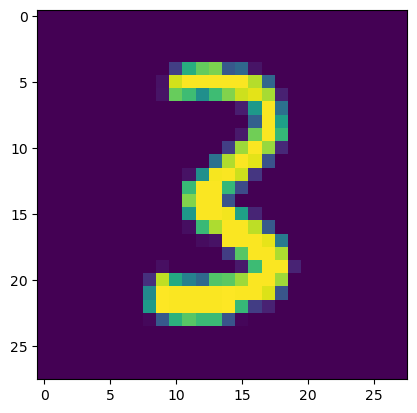

In [187]:
import matplotlib.pyplot as plt
plt.imshow(xb[0].view(28, 28)); yb[0]

In [188]:
def fit():
  for epoch in range(epochs):
    for xb, yb in trn_dl: # <<
      preds = model(xb)
      loss = loss_func(preds, yb)
      loss.backward()
      opt.step()
      opt.zero_grad()
    report(loss, preds, yb)

In [189]:
model, opt = get_model()
fit()

Loss: 0.79; Accuracy: 0.82
Loss: 0.49; Accuracy: 0.84
Loss: 0.30; Accuracy: 0.88


And just like that, we have abstracted our loading logic from three lines...
```py
for i in range(0, n, bs):
  s = slice(i, min(n, bs+i))
  xb, yb = trn_x[s], trn_y[s]
  ...
```
...to a much more readable single line.
```py
for xb, yb in trn_dl:
  ...
```

### Random Sampling

Sampling is the method by which the dataloader selects indices from the dataset to load. Sampling from the training set should be random (due to the nature of our data), but not for the validation set.

Therefore, we will need to create an additional class for the our dataloader; a component that tells the dataloader from which indices to load data from the dataset.

In [190]:
import random
?random.shuffle

Signature: random.shuffle(x, random=None)
Docstring:
Shuffle list x in place, and return None.

Optional argument random is a 0-argument function returning a
random float in [0.0, 1.0); if it is the default None, the
standard random.random will be used.
File:      ~/mambaforge/envs/default/lib/python3.10/random.py
Type:      method

In [191]:
class Sampler():
  def __init__(self, ds, shuffle=False): self.n,self.shuffle = len(ds),shuffle
  def __iter__(self):
    res = list(range(self.n))
    if self.shuffle: random.shuffle(res)
    return iter(res)

In [192]:
ss = Sampler(trn_ds); ss

In [193]:
#| column: margin
try: print(next(ss))
except: pass

:::{.column-margin}
This does not work because `__iter__` is not being called. `__iter__` only gets called when we wrap the class with `iter()`.
:::

In [194]:
#| column: margin
try: print(next(iter(ss)))
except: pass

0


In [195]:
it = iter(ss); it

In [196]:
for o in range(5): print(next(it))

0
1
2
3
4


The `Sampler` currently returns a single index in each iteration. We need to change that so a number of indices (equal to our batch size) is returned in each iteration. We can do this through a fancy slicing function known as `islice`.

In [197]:
from itertools import islice
?islice

Init signature: islice(self, /, *args, **kwargs)
Docstring:     
islice(iterable, stop) --> islice object
islice(iterable, start, stop[, step]) --> islice object

Return an iterator whose next() method returns selected values from an
iterable.  If start is specified, will skip all preceding elements;
otherwise, start defaults to zero.  Step defaults to one.  If
specified as another value, step determines how many values are
skipped between successive calls.  Works like a slice() on a list
but returns an iterator.
Type:           type
Subclasses:     

`iter` returns a single element from an iterable at a time. `islice` is a type of iterator that returns $x$ elements from an iterable at a time. It is an, erm, iterative slice.

In [198]:
list(islice(ss, 5))

[0, 1, 2, 3, 4]

Let's define an additional class that takes a sampler, and assembles its output into batches.

In [199]:
class BatchSampler:
  def __init__(self, sampler, bs, drop_last=False): store_attr()
  def __iter__(self): yield from chunked(iter(self.sampler), self.bs, drop_last=self.drop_last) # <1>

1. `fastcore`'s `chunked` function has the exact same functionality as `islice`, but with some extra quality of life features. This includes being able to specify how many chunks, or slices, we want back (rather than the number of elements in a chunk), as well as being able to specify whether we would like to drop, or keep, chunks that are smaller than our specified chunk size. This latter option is what we will use–it will abstract away the `min` check we use in our `DataLoader` (`self.ds[i:min(len(self.ds), i+self.bs)]`).

In [200]:
#| column: margin
??chunked

Signature: chunked(it, chunk_sz=None, drop_last=False, n_chunks=None)
Source:   
def chunked(it, chunk_sz=None, drop_last=False, n_chunks=None):
    "Return batches from iterator `it` of size `chunk_sz` (or return `n_chunks` total)"
    assert bool(chunk_sz) ^ bool(n_chunks)
    if n_chunks: chunk_sz = max(math.ceil(len(it)/n_chunks), 1)
    if not isinstance(it, Iterator): it = iter(it)
    while True:
        res = list(itertools.islice(it, chunk_sz))
        if res and (len(res)==chunk_sz or not drop_last): yield res
        if len(res)<chunk_sz: return
File:      ~/mambaforge/envs/default/lib/python3.10/site-packages/fastcore/basics.py
Type:      function

In [201]:
list(islice(ss, 5))

[0, 1, 2, 3, 4]

In [202]:
list(chunked(ss, 5))[:5]

[[0, 1, 2, 3, 4],
 [5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14],
 [15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [203]:
batches = BatchSampler(ss, 4)
list(islice(batches, 5))

[[0, 1, 2, 3],
 [4, 5, 6, 7],
 [8, 9, 10, 11],
 [12, 13, 14, 15],
 [16, 17, 18, 19]]

### Collation

There is one last piece of the puzzle left. Each sample in our `Dataset` also stores its associated target. We need to split these apart when dataloading. In other words, we need to split the data and target in each sample into their own batches; into an `x` batch and a `y` batch.

In [204]:
def collate(b):
  xs, ys = zip(*b)
  return torch.stack(xs), torch.stack(ys)

In [205]:
class DataLoader():
  def __init__(self, ds, batches, collate_fn=collate): store_attr()
  def __iter__(self): yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batches) # <<

Let's breakdown the latter line and explore what it does, piece by piece.

In [206]:
trn_samp = BatchSampler(Sampler(trn_ds, shuffle=True), bs)
vld_samp = BatchSampler(Sampler(vld_ds, shuffle=False), bs)

`for b in self.batches`, we loop through each batch.

In [207]:
b = next(iter(vld_samp)); b[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

`self.ds[i] for i in b`; using the indices in each batch, we access the respective samples in the dataset.

In [208]:
p = [vld_ds[i] for i in b]; len(p)

50

As can be seen below, `p` also stores the target.

In [209]:
p[0]

(tensor([0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
         0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
         0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
         0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
         0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
         0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.18, 0.62, 0.76, 0.80, 0.28, 0.34, 0.05, 0.00, 0.00, 0.00,
         0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.05, 0.93, 0.99, 0.99, 0.99,
         0.99

Then we simply run the collate function.

In [210]:
xs, ys = zip(*p); ys

(tensor(3),
 tensor(8),
 tensor(6),
 tensor(9),
 tensor(6),
 tensor(4),
 tensor(5),
 tensor(3),
 tensor(8),
 tensor(4),
 tensor(5),
 tensor(2),
 tensor(3),
 tensor(8),
 tensor(4),
 tensor(8),
 tensor(1),
 tensor(5),
 tensor(0),
 tensor(5),
 tensor(9),
 tensor(7),
 tensor(4),
 tensor(1),
 tensor(0),
 tensor(3),
 tensor(0),
 tensor(6),
 tensor(2),
 tensor(9),
 tensor(9),
 tensor(4),
 tensor(1),
 tensor(3),
 tensor(6),
 tensor(8),
 tensor(0),
 tensor(7),
 tensor(7),
 tensor(6),
 tensor(8),
 tensor(9),
 tensor(0),
 tensor(3),
 tensor(8),
 tensor(3),
 tensor(7),
 tensor(7),
 tensor(8),
 tensor(4))

And there we have our collated `x` and `y` batches!

In [211]:
torch.stack(ys)

tensor([3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3,
        8, 3, 7, 7, 8, 4])

In [212]:
trn_samp = BatchSampler(Sampler(trn_ds, shuffle=True), bs)
vld_samp = BatchSampler(Sampler(vld_ds, shuffle=False), bs)

In [213]:
trn_dl = DataLoader(trn_ds, batches=trn_samp)
vld_dl = DataLoader(vld_ds, batches=vld_samp)

tensor(3)

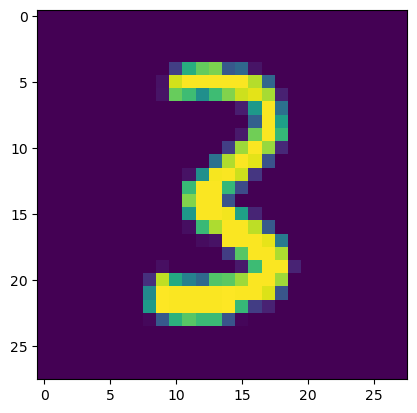

In [214]:
xb, yb = next(iter(vld_dl))
plt.imshow(xb[0].view(28, 28))
yb[0]

In [215]:
xb.shape, yb.shape

(torch.Size([50, 784]), torch.Size([50]))

In [216]:
model, opt = get_model()
fit()

Loss: 1.03; Accuracy: 0.74
Loss: 0.46; Accuracy: 0.82
Loss: 0.30; Accuracy: 0.90


We do not need to update the `fit()` function, as its logic remains the same despite our changes to the dataloader.

In [217]:
??fit

Signature: fit()
Docstring: <no docstring>
Source:   
def fit():
  for epoch in range(epochs):
    for xb, yb in trn_dl: # <<
      preds = model(xb)
      loss = loss_func(preds, yb)
      loss.backward()
      opt.step()
      opt.zero_grad()
    report(loss, preds, yb)
File:      /var/folders/fy/vg316qk1001227svr6d4d8l40000gn/T/ipykernel_52843/769712355.py
Type:      function

### Multiprocessing DataLoader

We can speed up how quickly data is loaded by using multiple CPU cores.

In [218]:
%%timeit
it = iter(trn_dl)

227 ns ± 1.45 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [219]:
import torch.multiprocessing as mp
class DataLoader():
  def __init__(self, ds, batches, n_workers=1, collate_fun=collate): store_attr()
  def __iter__(self):
    with mp.Pool(self.n_workers) as ex: yield from ex.map(self.ds.__getitem__, iter(self.batches))

In [220]:
trn_dl = DataLoader(trn_ds, batches=trn_samp, n_workers=4)

In [221]:
%%timeit
it = iter(trn_dl)

197 ns ± 0.557 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


Let's break down how exactly our `__iter__` method works.

We slice batches by specifying a list of indices.

In [222]:
trn_ds[[3, 6, 8, 1]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

Behind the scenes, the square bracket notation calls the `__getitem__` dunder method.

In [223]:
??trn_ds.__getitem__

Signature: trn_ds.__getitem__(i)
Docstring: <no docstring>
Source:      def __getitem__(self, i): return self.x[i], self.y[i]
File:      /var/folders/fy/vg316qk1001227svr6d4d8l40000gn/T/ipykernel_52843/694427655.py
Type:      method

In fact, we can index directly using `__getitem__`. 

In [224]:
trn_ds.__getitem__([3, 6, 8, 1])

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

Therefore, by dividing our batches into smaller sets, we can take advantage of the `__getitem__` dunder method to allow each CPU core to handle a separate set of items.

So we can divide our batches into smaller sets that each CPU core can manage.

In [225]:
len(list(map(trn_ds.__getitem__, ([3, 6], [8, 1]))))

2

In [226]:
for o in map(trn_ds.__getitem__, ([3, 6], [8, 1])): print(o)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 1]))
(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 0]))


### Sampling in PyTorch

In [227]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler
?BatchSampler

Init signature:
BatchSampler(
    sampler: Union[torch.utils.data.sampler.Sampler[int], Iterable[int]],
    batch_size: int,
    drop_last: bool,
) -> None
Docstring:     
Wraps another sampler to yield a mini-batch of indices.

Args:
    sampler (Sampler or Iterable): Base sampler. Can be any iterable object
    batch_size (int): Size of mini-batch.
    drop_last (bool): If ``True``, the sampler will drop the last batch if
        its size would be less than ``batch_size``

Example:
    >>> list(BatchSampler(SequentialSampler(range(10)), batch_size=3, drop_last=False))
    [[0, 1, 2], [3, 4, 5], [6, 7, 8], [9]]
    >>> list(BatchSampler(SequentialSampler(range(10)), batch_size=3, drop_last=True))
    [[0, 1, 2], [3, 4, 5], [6, 7, 8]]
File:           ~/mambaforge/envs/default/lib/python3.10/site-packages/torch/utils/data/sampler.py
Type:           type
Subclasses:     

PyTorch provides a wrapper which assembles the indices, sampled by our desired sampler, into batches.

In [228]:
?RandomSampler

Init signature:
RandomSampler(
    data_source: Sized,
    replacement: bool = False,
    num_samples: Optional[int] = None,
    generator=None,
) -> None
Docstring:     
Samples elements randomly. If without replacement, then sample from a shuffled dataset.
If with replacement, then user can specify :attr:`num_samples` to draw.

Args:
    data_source (Dataset): dataset to sample from
    replacement (bool): samples are drawn on-demand with replacement if ``True``, default=``False``
    num_samples (int): number of samples to draw, default=`len(dataset)`.
    generator (Generator): Generator used in sampling.
File:           ~/mambaforge/envs/default/lib/python3.10/site-packages/torch/utils/data/sampler.py
Type:           type
Subclasses:     

In [229]:
trn_samp = BatchSampler(    RandomSampler(trn_ds), bs, drop_last=False)
vld_samp = BatchSampler(SequentialSampler(vld_ds), bs, drop_last=False)

To construct a dataloader with PyTorch, we have to provide the dataset and a sampler.

In [230]:
?DataLoader

Init signature:
DataLoader(
    dataset: torch.utils.data.dataset.Dataset[+T_co],
    batch_size: Optional[int] = 1,
    shuffle: Optional[bool] = None,
    sampler: Union[torch.utils.data.sampler.Sampler, Iterable, NoneType] = None,
    batch_sampler: Union[torch.utils.data.sampler.Sampler[Sequence], Iterable[Sequence], NoneType] = None,
    num_workers: int = 0,
    collate_fn: Optional[Callable[[List[~T]], Any]] = None,
    pin_memory: bool = False,
    drop_last: bool = False,
    timeout: float = 0,
    worker_init_fn: Optional[Callable[[int], NoneType]] = None,
    multiprocessing_context=None,
    generator=None,
    *,
    prefetch_factor: Optional[int] = None,
    persistent_workers: bool = False,
    pin_memory_device: str = '',
)
Docstring:     
Data loader. Combines a dataset and a sampler, and provides an iterable over
the given dataset.

The :class:`~torch.utils.data.DataLoader` supports both map-style and
iterable-style datasets with single- or multi-process loading, cus

In [231]:
trn_dl = DataLoader(trn_ds, batch_sampler=trn_samp, collate_fn=collate)
vld_dl = DataLoader(vld_dl, batch_sampler=vld_samp, collate_fn=collate)

In [232]:
model, opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

Loss: 1.05; Accuracy: 0.64
Loss: 0.69; Accuracy: 0.72
Loss: 0.55; Accuracy: 0.84


(tensor(1.02, grad_fn=<NllLossBackward0>), tensor(0.66))

Instead of separately wrapping the `RandomSampler` and `SequentialSampler` classes, we can let the `DataLoader` class do this for us.

In [233]:
trn_dl = DataLoader(trn_ds, bs, sampler=    RandomSampler(trn_ds), collate_fn=collate)
vld_dl = DataLoader(vld_ds, bs, sampler=SequentialSampler(trn_ds), collate_fn=collate)

In fact, we don't even need to specify the sampler. All we have to do is toggle and set some parameters.

In [234]:
trn_dl = DataLoader(trn_ds, bs, shuffle=True, drop_last=True, num_workers=2)
vld_dl = DataLoader(vld_ds, bs, shuffle=False, num_workers=2)

In [235]:
model, opt = get_model(); fit()

Loss: 0.80; Accuracy: 0.80
Loss: 0.27; Accuracy: 0.94
Loss: 0.40; Accuracy: 0.88


In [236]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.84, grad_fn=<NllLossBackward0>), tensor(0.68))

As our dataset already knows how to sample a batch of indices all at once, we can actually skip the `batch_sampler` and `collate_fn` entirely. 🙃

```py
class Dataset():
  def __init__(self, x, y): self.x, self.y = x, y
  def __len__(self): return len(self.x)
  def __getitem__(self, i): return self.x[i], self.y[i]
```

In [237]:
trn_ds[[4, 6, 7]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([9, 1, 3]))

In [238]:
trn_dl = DataLoader(trn_ds, sampler=trn_samp)
vld_dl = DataLoader(vld_ds, sampler=vld_samp)

In [239]:
xb, yb = next(iter(trn_dl)); xb.shape, yb.shape

(torch.Size([1, 50, 784]), torch.Size([1, 50]))

## Validation

When training and evaluating a model, `model.train()` and `model.eval()` need to be called respectively. These methods are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour during different phases of the process.

In [240]:
?model.train

Signature: model.train(mode: bool = True) -> ~T
Docstring:
Sets the module in training mode.

This has any effect only on certain modules. See documentations of
particular modules for details of their behaviors in training/evaluation
mode, if they are affected, e.g. :class:`Dropout`, :class:`BatchNorm`,
etc.

Args:
    mode (bool): whether to set training mode (``True``) or evaluation
                 mode (``False``). Default: ``True``.

Returns:
    Module: self
File:      ~/mambaforge/envs/default/lib/python3.10/site-packages/torch/nn/modules/module.py
Type:      method

In [241]:
?model.eval

Signature: model.eval() -> ~T
Docstring:
Sets the module in evaluation mode.

This has any effect only on certain modules. See documentations of
particular modules for details of their behaviors in training/evaluation
mode, if they are affected, e.g. :class:`Dropout`, :class:`BatchNorm`,
etc.

This is equivalent with :meth:`self.train(False) <torch.nn.Module.train>`.

See :ref:`locally-disable-grad-doc` for a comparison between
`.eval()` and several similar mechanisms that may be confused with it.

Returns:
    Module: self
File:      ~/mambaforge/envs/default/lib/python3.10/site-packages/torch/nn/modules/module.py
Type:      method

In [242]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
  for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
      preds = model(xb)
      loss = loss_func(preds, yb)
      loss.backward()
      opt.step()
      opt.zero_grad()
    
    model.eval()
    with torch.no_grad():
      tot_loss, tot_acc, count = (0.,) * 3
      for xb, yb in valid_dl:
        preds = model(xb)
        n = len(xb)
        count += n
        tot_loss += loss_func(preds, yb).item() * n
        tot_acc  += accuracy (preds, yb).item() * n
    print(epoch, tot_loss/count, tot_acc/count)
  return tot_loss/count, tot_acc/count

In [243]:
def get_dls(trainn_ds, valid_ds, bs, **kwargs):
  return (DataLoader(trn_ds, batch_size=bs,   shuffle=True, **kwargs),
          DataLoader(vld_ds, batch_size=bs*2,               **kwargs))

In [244]:
trn_dl, vld_dl = get_dls(trn_ds, vld_ds, bs)
model, opt = get_model()

In [245]:
%time loss, acc = fit(5, model, loss_func, opt, trn_dl, vld_dl)

0 1.3015430688858032 0.6180000007152557
1 0.7089294970035553 0.7680000007152558
2 0.6260120451450348 0.7990000009536743
3 0.501511612534523 0.8490000128746032
4 0.5909725487232208 0.8119999945163727
CPU times: user 1.55 s, sys: 41.8 ms, total: 1.59 s
Wall time: 358 ms


## Conclusion

If you have any comments, questions, suggestions, feedback, criticisms, or corrections, please do post them down in the comment section below!